In [1]:
import os
import json
import numpy as np
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
from skimage import io

In [2]:
import datetime

from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:

# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2

!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

!pip install cython
# Install pycocotools, the version by default in Colab
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U albumentations
!pip install -U opencv-python

#Copy and unify the train and validation datasets into one folder for images and another for labels
!mkdir ./train
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/images/. ./train/images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/images/. ./train/images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/labels/. ./train/labels/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/labels/. ./train/labels/

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


ERROR: Invalid requirement: "'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'": Expected package name at the start of dependency specifier
    'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    ^
Hint: = is not a valid operator. Did you mean == ?


The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import utils
# import transforms as T  # Use OpenCV or Pillow for image transformations instead
import cv2
import time
# from albumentations.pytorch.transforms import ToTensorV2  # Use PyTorch or other framework-specific modules
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats  # Alternative for statistical functions
from PIL import Image  # Alternative for basic image transformations
import random


In [5]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background','Crater']
        
    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
def get_model_bbox(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [8]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [9]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

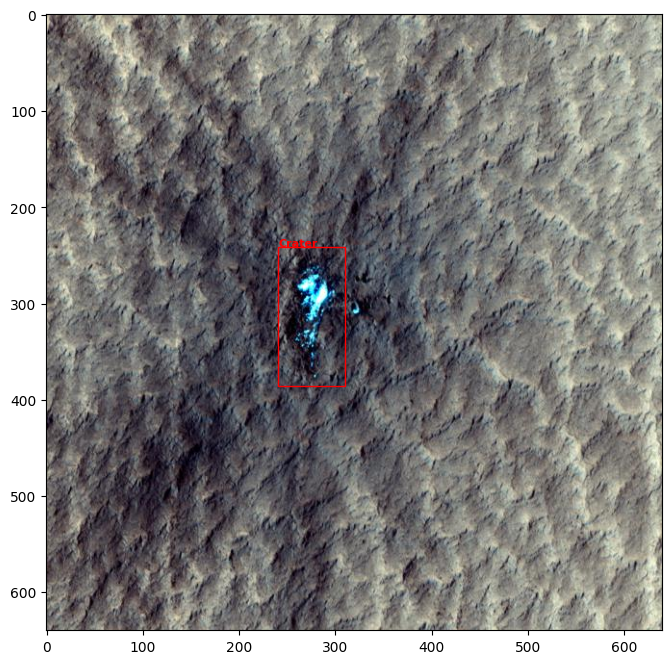

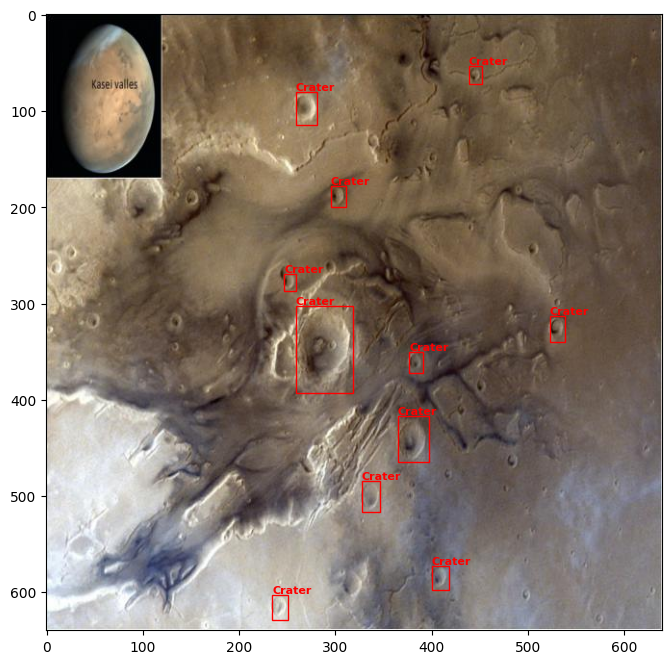

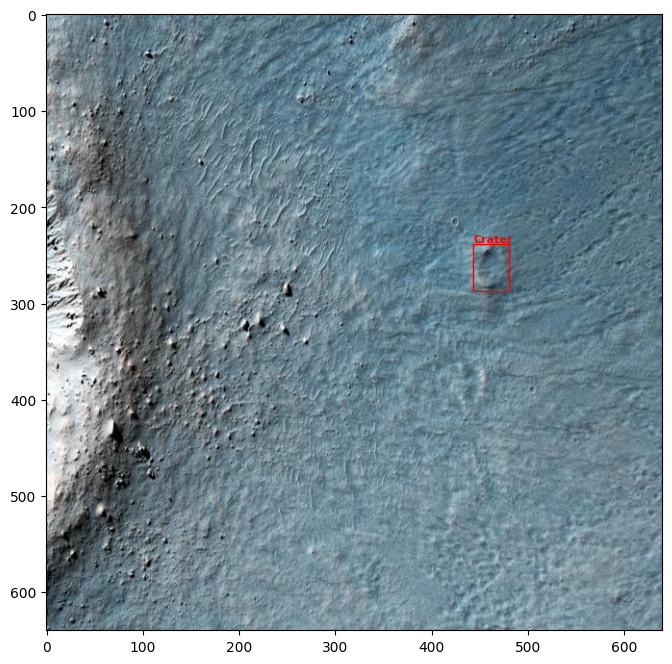

In [34]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

class CraterBoulderDataset:
    def __init__(self, images_dir, labels_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_paths = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))  # Adjust file extension as per your images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = os.path.join(self.labels_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')

        # Load image
        img = plt.imread(img_path)

        # Load labels
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_label = int(parts[0])  # Assuming class label is present
                        x_center = float(parts[1]) * img.shape[1]  # Convert to absolute coordinates
                        y_center = float(parts[2]) * img.shape[0]
                        width = float(parts[3]) * img.shape[1]
                        height = float(parts[4]) * img.shape[0]
                        labels.append({
                            'class_label': class_label,
                            'x_center': x_center,
                            'y_center': y_center,
                            'width': width,
                            'height': height
                        })

        return img, labels

# Example usage
images_dir = r'D:\Prayag Files\TIET\Extras\Internship\Ongoing\hexagon\craters\train\images'
labels_dir = r'D:\Prayag Files\TIET\Extras\Internship\Ongoing\hexagon\craters\train\labels'

dataset = CraterBoulderDataset(images_dir, labels_dir)

# Plotting function with 'Crater' annotation and red color
def plot_img_bbox(img, labels):
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    a.imshow(img)

    for label in labels:
        x_center = label['x_center']
        y_center = label['y_center']
        width = label['width']
        height = label['height']

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        rect = patches.Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min),
                                 edgecolor='r', facecolor='none', clip_on=False)  # Changed color to red
        a.add_patch(rect)
        a.annotate('Crater', (x_min, y_min - 10), color='red', weight='bold',  # Changed color to red
                   fontsize=8, ha='left', va='top')

    plt.show()

# Print 3 random examples to check annotations with red color
for idx in random.sample(range(len(dataset)), 3):
    img, labels = dataset[idx]
    plot_img_bbox(img, labels)


In [70]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import os
import numpy as np
from PIL import Image
import math
import sys
from collections import deque, defaultdict

# Define the CraterDataset class
class CraterDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.txt'))
        try:
            img = Image.open(img_path).convert("RGB")
            img = np.array(img)

            boxes = []
            labels = []

            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        label = int(parts[0])
                        x_min, y_min, x_max, y_max = map(float, parts[1:])
                        if x_min < x_max and y_min < y_max:  # Ensure valid bounding box
                            boxes.append([x_min, y_min, x_max, y_max])
                            labels.append(label)
            
            if len(boxes) == 0:  # Ensure there is at least one valid bounding box
                return None, None
            
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            target = {
                "boxes": boxes,
                "labels": labels
            }

            if self.transform:
                img = self.transform(img)

            return img, target
        except Exception as e:
            print(f"Error loading image {img_path} or label {label_path}: {e}")
            return None, None

# Define transformations for training and validation
def get_transform(train):
    base_transform = [transforms.ToTensor()]
    if train:
        base_transform.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(base_transform)

# Define custom collate function for object detection datasets
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None and x[1] is not None, batch))
    if not batch:
        return [], []
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# MetricLogger and SmoothedValue classes
class SmoothedValue:
    def __init__(self, window_size=20, fmt=None):
        self.deque = deque(maxlen=window_size)
        self.fmt = fmt if fmt else "{value:.3f}"
    
    def update(self, value):
        self.deque.append(value)
    
    def __str__(self):
        return self.fmt.format(value=np.mean(self.deque))

class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter
    
    def update(self, **kwargs):
        for k, v in kwargs.items():
            if k in self.meters:
                self.meters[k].update(v)
            else:
                self.meters[k] = SmoothedValue(fmt="{value:.3f}")
    
    def __str__(self):
        return self.delimiter.join(
            [f"{name}: {meter}" for name, meter in self.meters.items()]
        )
    
    def add_meter(self, name, meter):
        self.meters[name] = meter
    
    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if header:
            print(header)
        for obj in iterable:
            yield obj
            if i % print_freq == 0:
                print(self)
            i += 1

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Calculate total loss
        losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update metrics
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        # Print metrics
        print(metric_logger)

# Evaluate function (dummy, replace with actual implementation if available)
def evaluate(model, data_loader, device):
    # Dummy evaluation function
    model.eval()
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        # Add your evaluation logic here

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Constants
k_folds = 5
num_epochs = 50
num_classes = 2  # Assuming two classes: background and crater

# Define your dataset and transformations
dataset = CraterDataset(
    image_dir='D:\\Prayag Files\\TIET\\Extras\\Internship\\Ongoing\\hexagon\\craters\\train\\images',
    label_dir='D:\\Prayag Files\\TIET\\Extras\\Internship\\Ongoing\\hexagon\\craters\\train\\labels',
    transform=get_transform(train=True)
)
dataset_val = CraterDataset(
    image_dir='D:\\Prayag Files\\TIET\\Extras\\Internship\\Ongoing\\hexagon\\craters\\train\\images',
    label_dir='D:\\Prayag Files\\TIET\\Extras\\Internship\\Ongoing\\hexagon\\craters\\train\\labels',
    transform=get_transform(train=False)
)

# Initialize K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Subset datasets for training and validation
    train_dataset = Subset(dataset, train_ids)
    val_dataset = Subset(dataset_val, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

    # Get the model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # Replace or modify the final layer for your specific number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)

    # Move model to the right device
    model.to(device)

    # Define optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the model for num_epochs
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
        lr_scheduler.step()

    # Evaluate the model on validation data
    evaluate(model, val_loader, device=device)

    # Optional: Save model weights for each fold
    # torch.save(model.state_dict(), f'fold_{fold}_model.pth')

    print(f"End of Fold {fold}\n")

print("Training complete.")


--------------------------------
FOLD 0
--------------------------------
Epoch: [0]


ValueError: too many values to unpack (expected 2)